# Analysing Topical Shifts in Migration Publication via Title Words

The titles of publications on migration management give us an overview of what the scientific community focused in their research over the decades.

The dataset consists of authors, titles and publication year of articles published in the journal International Migration (IM) over the period 1961-2011. 



## Loading and inspecting the dataset

We start by loading the dataset in Pandas, which allows us to do basic analysis of the metadata.

In [1]:
import pandas as pd

# the name and location of the article records for the IM journal (in CSV format)
wiley_file = '../data/wileyrecs.csv'

# load the csv data into a data frame
df = pd.read_csv(wiley_file)
# show the first and last records of the dataset to demonstrate what the records look like
df

,AU,TI,PY,JO
0,NaN,The New Director Of Icem,1961.0,Migracion
1,"Perotti, Antonio",The Migration Problem And The Encyclical “Mate...,1961.0,Migracion
2,"Marsal, Juan F.",Argentina As An Immigration Country,1961.0,Migracion
3,"Dominedo, M.",How Migration Affects The Country Of Emigration,1961.0,Migracion
4,"Zubrzycki, Jerzy",Sociological Methods For The Study Of Immigran...,1961.0,Migracion
...,...,...,...,...
1141,"Düvell, Franck",Introduction,2011.0,International Migration
1142,"Jandl, Michael","Methods, Approaches and Data Sources for Estim...",2011.0,International Migration
1143,"Prescott, Hannah",The Size of the Irregular Migrant Population i...,2011.0,International Migration
1144,"Reichel, David",Measuring Irregular Migration and Population F...,2011.0,International Migration


### Basic summary statistics

A conut of the values in the journal name column ('JO'), reveals that the metadata of articles has some variation, but almost all use the canonical _International Migration_.

This should also be a warning that some values in the record may be _incorrect_, _incomplete_ and/or _inconsistent_, so quantitative analysis should always be complemented with qualitative analysis.

In [2]:
df.JO.value_counts()

International Migration    1103
Migracion                    22
Migration                    19
Name: JO, dtype: int64

#### Authors

There are many different authors in the dataset. A value count reveals that some authors published multiple articles in IM, but the majority published only a single article. 

In [3]:
df.AU.value_counts()

Appleyard, Reginald      9
Adepoju, Aderanti        7
BEYER, G.                6
Martin, Susan            5
Beyer, G.                5
                        ..
Mattila, Heikki S.       1
Sinclair, Marion Ryan    1
Kirisci, K.              1
Carey, Malcolm           1
FEIL, CHRISTINE          1
Name: AU, Length: 932, dtype: int64

These author names need normalisation to collapse variants like `BEYER, G.` and `Beyer, G.`.

In [4]:
df.AU.str.lower().str.title().value_counts()

Beyer, G.              11
Appleyard, Reginald     9
Adepoju, Aderanti       7
Moncarz, Raul           6
Bernard, William S.     5
                       ..
Mullan, B. P.           1
Daly, Marcus            1
Abella, Manolo I.       1
Waldstein, Anna         1
Zlotnik, H.             1
Name: AU, Length: 899, dtype: int64

This reduces the number of distinct values from 932 to 899, so the impact is small, although Gunther Beyer is now the most frequent author in the dataset.

In [5]:
df.AU.str.lower().str.title().value_counts().value_counts()

1     786
2      80
3      19
4       7
5       3
11      1
9       1
7       1
6       1
Name: AU, dtype: int64

There are 786 author names that appear only once, and only a handful authored 4 or more articles. 

#### Publication Years

Counting the number of articles per year reveals that some years had very few articles (e.g. 1979 has only 1), but most years have more than 10. The number of articles per year seems to increase over time. 

<AxesSubplot:>

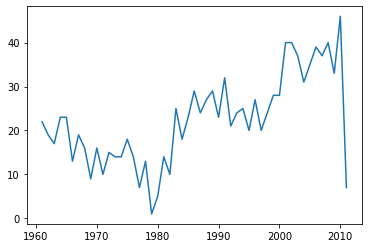

In [6]:
df.PY.value_counts().sort_index().plot()

## Analysing the Article Titles

To analyse the topics of discourse, we use the article titles. To do a content analysis, some data transformations are needed:

- standardising the use of upper and lowercase characters,
- removing common stopwords, as they convey nothing about the topics discussed
- counting individual words and sequences of words as a quantitative signal for the attention to different topics.

We look specifically at:

- word unigram frequencies: how often individual words occur across titles
- word bigram frequencies: how often combinations of two words occur across titles.

To demonstrate the need for the transformations described above, we look at the first 20 titles.

In [7]:
# Get a list of all the titles
titles = list(df.TI)

# show the first 20 titles
titles[:20]



['The New Director Of Icem',
 'The Migration Problem And The Encyclical “Mater Et Magistra”',
 'Argentina As An Immigration Country',
 'How Migration Affects The Country Of Emigration',
 'Sociological Methods For The Study Of Immigrant Adjustement',
 'Foreword',
 'Editorial',
 'The Influence Of Migration On Australian Foreign Policy*',
 'Prospects And Machinery Of European Migration Movements Within The European Economic Community',
 'The Importance Of Immigration In The Development Of Brazil',
 'Emigration From Greece',
 'Information',
 'Resolutions Of The Thirteenth Session Of The Council Of The Intergovernmental Committee For European Migration',
 'Book Reviews',
 'Bibliography',
 nan,
 'INTERGOVERNMENTAL PARTNERSHIP FOR PLANNED MIGRATION',
 'THE REPORT OF THE INTERGOVERNMENTAL COMMITTEE FOR EUROPEAN MIGRATION FOR THE YEAR 1960',
 'GREEK IMMIGRANTS IN AUSTRALIA',
 nan]

#### Inconsistent Case

The titles differ in their use of upper and lower case, so one step is to normalise all titles to be lower case. 

One consequence of this is that meaningful differences between a word with an initial uppercase that is part of a name (like _Migration_ in the organisation name _Internationl Committee for European Migration_) is merged with the regular noun _migration_. But in most cases this is not a problem, as they represent the same concept. Moreover, titles of journal article tend to use title casing of all words in the title, or at least all content-bearing words (i.e. non-stopwords). So it is difficult to make this distinction with algorithmic processing anyway.

#### Missing titles

Another thing we note is that the last value in the list is `nan`, which stands for `Not a Number` and is Pandas' way of warning us that there is no value for the row in the dataset. What it means for us is that there is an entry that has no title. For now we will skip these missing titles in the word cloud analysis.

But first let us see how prevalent they are. If a significant fraction of articles have no title, the title word analysis might not be a good reflection of the actual frequencies of title words.


In [8]:
missing_titles = [title for title in titles if not isinstance(title, str)]
print('Total number of article titles:', len(titles))
print('Number of missing article titles:', len(missing_titles))


Total number of article titles: 1146
Number of missing article titles: 2


Only two out of 1146 titles are missing, which will have a negligible affect on the analysis.

In [9]:
# we remove the missing titles and continue the analysis with the 1144 remaining actual titles.
titles = [title for title in titles if isinstance(title, str)]

len(titles)

1144

### Word Frequency Lists

We start with a quick look at individual word frequencies for the first 20 titles to get an insight in some easy that need preprossing.

In [10]:
from collections import Counter # import to count word frequencies


# count frequencies of individual words
uni_freq = Counter()

for title in titles[:20]:
    # .lower() transform all characters to lower case
    # .split(' ') splits the title into chunks wherever there is a whitespace
    terms = title.lower().split(' ')
    uni_freq.update(terms)

# Show the 25 most common words and their frequencies
for term, freq in uni_freq.most_common(25):
    print(f'{term: <30}{freq: >5}')

the                              16
of                               12
migration                         8
for                               5
european                          4
in                                4
and                               3
intergovernmental                 3
immigration                       2
country                           2
emigration                        2
development                       2
brazil                            2
committee                         2
new                               1
director                          1
icem                              1
problem                           1
encyclical                        1
“mater                            1
et                                1
magistra”                         1
argentina                         1
as                                1
an                                1


Our first attempt is to simply split the title on whitespaces, but that leaves punctuation as part of words, e.g. `“Mater`.

The next preprocessing step is removing punctuation from the titles.

In [11]:
from collections import Counter # import to count word frequencies
import re # import to remove punctuation

# count frequencies of individual words
uni_freq = Counter()

for title in titles[:20]:
    # First, transform characters to lowercase
    clean_title = title.lower()
    # split the transformed string on whitespace
    terms = clean_title.split(' ')
    # replace punctuation with nothing (i.e. remove from the word)
    terms = [re.sub(r'\W', '', term) for term in terms]
    uni_freq.update(terms)

for term, freq in uni_freq.most_common(25):
    print(f'{term: <30}{freq: >5}')
    



the                              16
of                               12
migration                         8
for                               5
european                          4
in                                4
and                               3
immigration                       3
intergovernmental                 3
country                           2
emigration                        2
development                       2
brazil                            2
committee                         2
new                               1
director                          1
icem                              1
problem                           1
encyclical                        1
mater                             1
et                                1
magistra                          1
argentina                         1
as                                1
an                                1


#### Stopwords and Content Words

Now we notice that the most frequent words are stopwords. We can use a standard stopword list provided by [NLTK](http://www.nltk.org) to remove those from the frequency lists to focus on the content words.

In [12]:
from collections import Counter # import to count word frequencies
import re # import to remove punctuation
from nltk.corpus import stopwords # import to remove stopwords

stopwords = stopwords.words('english')

print('The first 10 stopwords:', stopwords[:10])
print('\nTotal number of distinct stopwords:', len(stopwords))

The first 10 stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']

Total number of distinct stopwords: 153


In [13]:
# count frequencies of individual words
uni_freq = Counter()

for title in titles[:20]:
    # First, transform characters to lowercase
    clean_title = title.lower()
    # split the transformed string on whitespace
    terms = clean_title.split(' ')
    # replace punctuation with nothing (i.e. remove from the word)
    terms = [re.sub(r'\W', '', term) for term in terms]
    # remove stopwords
    terms = [term for term in terms if term not in stopwords]
    uni_freq.update(terms)

for term, freq in uni_freq.most_common(25):
    print(f'{term: <30}{freq: >5}')
    



migration                         8
european                          4
immigration                       3
intergovernmental                 3
country                           2
emigration                        2
development                       2
brazil                            2
committee                         2
new                               1
director                          1
icem                              1
problem                           1
encyclical                        1
mater                             1
et                                1
magistra                          1
argentina                         1
affects                           1
sociological                      1
methods                           1
study                             1
immigrant                         1
adjustement                       1
foreword                          1


Now we have a list of mostly content words. Note that the stopwords list contains English stopwords, so common stopwords in other languages are not filtered out. We assume these are not very common so will leave them in for now. 

Now we repeat the the frequency counting for all 1144 titles, instead of the first 20.

In [14]:
# count frequencies of individual words
uni_freq = Counter()

for title in titles:
    # First, transform characters to lowercase
    clean_title = title.lower()
    # split the transformed string on whitespace
    terms = clean_title.split(' ')
    # replace punctuation with nothing (i.e. remove from the word)
    terms = [re.sub(r'\W', '', term) for term in terms]
    # remove stopwords
    terms = [term for term in terms if term not in stopwords]
    uni_freq.update(terms)

for term, freq in uni_freq.most_common(25):
    print(f'{term: <30}{freq: >5}')
    



migration                       330
immigrants                       96
migrants                         82
immigration                      77
international                    73
labour                           66
case                             64
de                               60
australia                        56
migrant                          56
united                           53
emigration                       52
countries                        52
policy                           50
new                              48
immigrant                        48
states                           47
refugees                         47
economic                         46
social                           46
return                           45
development                      42
workers                          42
women                            42
en                               41


#### Word Bigrams

Next, we look at combinations of two words. Individual words can have quite different meanings in different contexts. Two neighbouring words in a title tend to contextualise each other, so convey more meaning.

In [15]:
# count frequencies of individual words
bi_freq = Counter()

for title in titles:
    # First, transform characters to lowercase
    clean_title = title.lower()
    # split the transformed string on whitespace
    terms = clean_title.split(' ')
    # replace punctuation with nothing (i.e. remove from the word)
    terms = [re.sub(r'\W', '', term) for term in terms]
    # get all pairs of subsequent title words
    bigrams = list(zip(terms[:-1], terms[1:]))
    # remove all bigrams for which the first or second word is a stopword
    bigram_terms = [' '.join(bigram) for bigram in bigrams if bigram[0] not in stopwords and bigram[1] not in stopwords]
    # count the occurrence of each bigram
    bi_freq.update(bigram_terms)


for term, freq in bi_freq.most_common(25):
    print(f'{term: <30}{freq: >5}')
    



international migration          50
united states                    43
labour migration                 19
brain drain                      18
case study                       18
return migration                 16
emigration dynamics              16
labour market                    15
migrant workers                  14
immigration policy               13
migrant women                    13
developing countries             12
human trafficking                12
human rights                      9
new zealand                       9
latin america                     8
books periodicals                 8
de la                             8
migration policy                  8
middle east                       8
current trends                    8
former soviet                     8
european migration                7
periodicals pamphlets             7
pamphlets statistics              7


Now, 'international migration' is the most common two-word combination, followed by 'United States', 'labour migration', 'brain drain' and 'case study'.

### Analysing Title Words Per Decade

The articles are published over a period of several decades, and there might be shifts in the discourse over time. A next step is to group uni-grams and bi-grams per decade, to visualise shifts.

In [16]:
def make_title_unigram_term_list(title: str, stopwords):
    # First, transform characters to lowercase
    clean_title = title.lower()
    # split the transformed string on whitespace
    terms = clean_title.split(' ')
    # replace punctuation with nothing (i.e. remove from the word)
    terms = [re.sub(r'\W', '', term) for term in terms]
    # remove stopwords
    terms = [term for term in terms if term not in stopwords]
    return terms


def make_title_bigram_term_list(title: str, stopwords):
    # first turn the title into a list of normalised words
    terms = make_title_unigram_term_list(title, stopwords)
    # get all pairs of subsequent title words
    bigrams = list(zip(terms[:-1], terms[1:]))
    # remove all bigrams for which the first or second word is a stopword
    bigram_terms = [' '.join(bigram) for bigram in bigrams 
                    if bigram[0] not in stopwords and bigram[1] not in stopwords]
    return bigram_terms


def normalise_title(title: str):
    if not isinstance(title, str):
        return title
    terms = make_title_unigram_term_list(title, [])
    normalised_title = ' '.join(terms)
    return normalised_title


# Add the normalised title as extra column to the data frame
df['title'] = df.TI.apply(normalise_title)
df.title

0                                the new director of icem
1       the migration problem and the encyclical mater...
2                     argentina as an immigration country
3         how migration affects the country of emigration
4       sociological methods for the study of immigran...
                              ...                        
1141                                         introduction
1142    methods approaches and data sources for estima...
1143    the size of the irregular migrant population i...
1144    measuring irregular migration and population f...
1145    irregular migration and informal economy in so...
Name: title, Length: 1146, dtype: object

In [17]:
df['decade'] = df.PY.apply(lambda x: int(x/10) * 10 if not pd.isnull(x) else x)
df[['PY', 'decade']]

,PY,decade
0,1961.0,1960.0
1,1961.0,1960.0
2,1961.0,1960.0
3,1961.0,1960.0
4,1961.0,1960.0
...,...,...
1141,2011.0,2010.0
1142,2011.0,2010.0
1143,2011.0,2010.0
1144,2011.0,2010.0


The number of articles per decade:

In [18]:
df.decade.value_counts().sort_index()

1960.0    161
1970.0    122
1980.0    204
1990.0    244
2000.0    360
2010.0     53
Name: decade, dtype: int64

In [19]:
decades = sorted([int(decade) for decade in list(set(df.decade)) if not pd.isnull(decade)])
decades

[1960, 1970, 1980, 1990, 2000, 2010]

In [20]:
from nltk.corpus import stopwords


# include stopwords from three languages in which articles were written
all_stopwords = stopwords.words('english') + stopwords.words('french') + stopwords.words('spanish')


for decade in decades:
    titles = list(df[df.decade == decade].title)
    unigram_terms = [term for title in titles for term in make_title_unigram_term_list(title, all_stopwords)]
    unigram_freq = Counter(unigram_terms)
    print(decade)
    print('--------------------------')
    for term, freq in unigram_freq.most_common(25):
        print(f'{term: <30}{freq: >5}')
    print('\n\n')
    



1960
--------------------------
migration                        34
immigration                      17
emigration                       13
australia                        12
european                         11
immigrants                       11
america                          10
international                     9
australian                        8
development                       8
latin                             8
social                            7
assimilation                      7
icem                              6
immigrant                         6
countries                         6
country                           5
economic                          5
europe                            5
western                           5
latine                            5
migrants                          5
italian                           5
study                             4
influence                         4



1970
--------------------------
migration                        

In [21]:
from nltk.corpus import stopwords


# include stopwords from three languages in which articles were written
all_stopwords = stopwords.words('english') + stopwords.words('french') + stopwords.words('spanish')


for decade in decades:
    titles = list(df[df.decade == decade].title)
    bigram_terms = [term for title in titles for term in make_title_bigram_term_list(title, all_stopwords)]
    bigram_freq = Counter(bigram_terms)
    print(decade)
    print('--------------------------')
    for term, freq in bigram_freq.most_common(25):
        print(f'{term: <30}{freq: >5}')
    print('\n\n')
    



1960
--------------------------
latin america                     8
european migration                4
international migration           4
italian emigration                4
intergovernmental committee       3
committee european                3
immigrants australia              3
amérique latine                   3
western australia                 3
brain drain                       3
migration affects                 2
affects country                   2
immigration development           2
report intergovernmental          2
migration year                    2
council europe                    2
international labour              2
movement workers                  2
migration australia               2
economic social                   2
meeting migrations                2
migrations countries              2
recent publications               2
rural settlement                  2
united states                     2



1970
--------------------------
united states                    